# Jitter amplification in our X-band linac from 100 to 500 MeV

In [1]:
import RF_Track as RFT
import numpy as np
import matplotlib.pyplot as plt

## Load the field map from a file
This field map is inspired by the structure presented in this paper: 

W. L. Millar et al., "High-Power Test of Two Prototype X-Band Accelerating Structures Based on SwissFEL Fabrication Technology," in IEEE Transactions on Nuclear Science, vol. 70, no. 1, pp. 1-19, Jan. 2023, doi: 10.1109/TNS.2022.3230567. https://ieeexplore.ieee.org/document/9991980

In [2]:
T = np.loadtxt('data/TWS_Xband.dat')

## Prepare for the RF-Track element

In [3]:
Ez = T[:,1] + 1j*T[:,2] # MV/m
hz = T[1,0] - T[0,0] # m

Let's plot it to see what it looks like

In [4]:
plt.plot(T[:,0], Ez.real)
plt.plot(T[:,0], Ez.imag)

## Create a new element
The field map was computed assuming 37.5 MW input power to provide a 100 MV/m peak field. We want to operate this structure at an 80 MV/m peak field. In a TW structure, the power and the gradient are related by the following expression: $$G = \sqrt{\frac{\omega r/Q P}{v_g}}.$$ 

Assuming a linear relationship between the gradient $G$ and the max $E_z$ field, the required input power must be reduced according to the following expression:
$$
P_\text{actual} = P_\text{map}\left( {\frac{E_\text{z max, actual}}{E_\text{z max, map}}} \right)^2.
$$

Like in the previous example, we create a new element of type RF_FieldMap_1D, but, this time, we add two new arguments to the constructor, $ P_\text{map}$ and $P_\text{actual}$ to specify our operating input power.

In [5]:
freq = 11.9942e9; # Hz
phid = np.deg2rad(0.0) # degrees

E_map = 100e6 # V/m, the max Ez
E_actual = 80e6# % V/m, our max Ez 

P_map = 37.5e6 # % W, the field map was generated assuming 37.5 MW input power, to provide 100 MV/m max Ez
P_actual = P_map * E_actual**2 / E_map**2 # W, we want to operate at 80 MV/m

RF = RFT.RF_FieldMap_1d(Ez, hz, -1, freq, +1, P_map, P_actual)
RF.set_phid(phid)
RF.set_nsteps(1000)

Let's plot the field using ```get_field()```

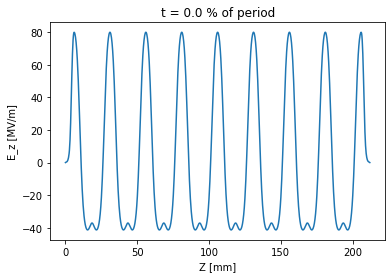

In [6]:
RF.set_t0(0.0) # for plotting
T_period = RF.get_period() # mm/c

Z = np.linspace(0, RF.get_length()*1e3, 1000) # mm
O = np.zeros(Z.size)
I = np.ones(Z.size);

for t in np.array([0.0,0.3,0.6])*T_period:
    #read the field
    E, B  = RF.get_field(O, O, Z, t*I)
    plt.figure()
    plt.plot(Z, E[:,2] / 1e6)
    plt.title('t = {} % of period'.format(t*100/T_period))
    plt.xlabel('Z [mm]')
    plt.ylabel('E_z [MV/m]')

RF.unset_t0()

In [7]:
L_RF = RF.get_length()

## Let's define some beam parameters

In [8]:
# Bunch parameters
mass = RFT.electronmass # MeV/c^2
Q = -1 # single-particle charge, in units of e
population = 50 * RFT.pC # number of real particles per bunch

P_i = 100 # initial momentum, MeV/c
P_f = 500 # final momentum, MeV/c

## Let's build the linac lattice
We use a standard FODO lattice, with four structures every two consecutive quadrupoles and 90 degrees phase advance per cell

In [9]:
# FODO cell parameters
Lquad = 0.1 # m
Lcell = 8*L_RF + 2*Lquad # m, eight structures and two quadrupoles

In [10]:
mu = np.deg2rad(90) # deg
k1L = np.sin(mu/2) / (Lcell/4) # 1/m
k1 = k1L / Lquad # 1/m^2

### The unit FODO cell
Each FODO cell can be considered as an RF module.
Initially, we leave the quadrupoles off; their strength is 0.0.

In [11]:
FODO = RFT.Lattice()
FODO.append(RF)
FODO.append(RF)
FODO.append(RF)
FODO.append(RF)
FODO.append(RFT.Quadrupole(Lquad, 0.0)) # initial strength to zero -> set automatically using Ref part
FODO.append(RF)
FODO.append(RF)
FODO.append(RF)
FODO.append(RF)
FODO.append(RFT.Quadrupole(Lquad, 0.0))

We need to find what is the maximum energy gain per cell, so we define a reference particle and track it through the cell

In [12]:
# Define the reference particle
P0 = RFT.Bunch6d(mass, population, Q, np.array([0,0,0,0,0,P_i]).T)

# We use "autophase" to set the phases and to determine P_final, the maximum final momentum
P_final = FODO.autophase(P0) # MeV/c

# The momentum gain is
P_gain = P_final - P_i   # MeV/c

print(P_final)
print(P_gain)

198.37528426556662
98.37528426556662


Let's compute how many FODO cells we need

In [13]:
n_FODO = (P_f - P_i) / P_gain

In [14]:
n_FODO = int(np.round(n_FODO))    # let's round it to the nearest integer
print(n_FODO)

4


As we intend to use several instances of the same FODO cell, we need to unset the reference time from FODO so that we can put four cells in a lattice and have each have its own reference time.

In [15]:
FODO.unset_t0()

# Start a new lattice
LINAC = RFT.Lattice()

# 1/2 quad, let's start with half a quad
LINAC.append(RFT.Quadrupole(Lquad/2, 0.0))

# let's put out n_FODO cells
for i in range(n_FODO):
    LINAC.append(FODO)

In [16]:
LINAC.get_length()

7.632659196799999

## Let's track the reference particle and do some plots

In [17]:
# Track the reference particle
P1 = LINAC.track(P0)

Plot the energy profile along the linac

In [18]:
# Extract the "transport table"
T = LINAC.get_transport_table('%S %mean_P')

plt.plot (T[:, 0], T[:, 1])
plt.xlabel ('s [m]')
plt.ylabel ('K [MeV]')

Text(0, 0.5, 'K [MeV]')

Now, we need to set the quadrupole strengths. We can use ```set_K1```, which accepts two parameters:
* the reference rigidity, $P/q$
* the quadrupole's focusing strength, in 1/m$^2$

In [19]:
Quads = LINAC.get_quadrupoles()

In [20]:
len(Quads)

9

It is convenient to use the normalised focusing strength, $k_1$

In [21]:
k1 = k1L / Lquad # 1/m^2

half_P_gain = 0.5 * P_gain

P = P_i # initial momentum
for q in Quads:
  # set quadrupole strength
  q.set_K1 (P/Q, k1)
  # update the momentum variable
  P += half_P_gain
  # changes the sign of k1, anticipating the next quadrupole
  k1 = -k1

## Define a bunch

In [22]:
# Define Twiss parameters
Twiss = RFT.Bunch6d_twiss()
Twiss.emitt_x = 5 # mm.mrad, normalized emittances
Twiss.emitt_y = 5 # mm.mrad
Twiss.beta_x = Lcell * (1 - np.sin(mu/2)) / np.sin(mu) # m
Twiss.beta_y = Lcell * (1 + np.sin(mu/2)) / np.sin(mu) # m

# Create the bunch
B0 = RFT.Bunch6d(mass, population, Q, P_i, Twiss, 10000);

## Perform tracking

In [23]:
B1 = LINAC.track(B0)

Let's make some plots...

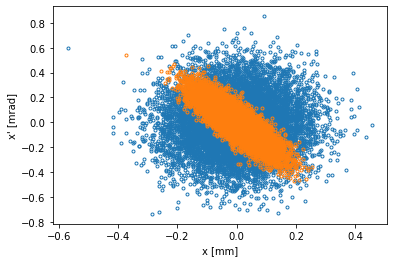

In [24]:
M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P')
M1 = B1.get_phase_space ('%x %xp %y %yp %dt %P')

plt.figure()
plt.plot(M0[:,0], M0[:,1], '.', label='Initial', mfc='none')
plt.plot(M1[:,0], M1[:,1], '.', label='Final', mfc='none')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")

plt.figure()
plt.plot(M0[:,2], M0[:,3], '.', label='Initial', mfc='none')
plt.plot(M1[:,2], M1[:,3], '.', label='Final', mfc='none')
plt.xlabel('y [mm]')
plt.ylabel("y' [mrad]")

plt.figure()
plt.plot(M1[:,4], M1[:,5], '.', label='Final', mfc='none')
plt.xlabel('dt [mm/c]')
plt.ylabel('P [MeV/c]')
plt.tight_layout()

In [25]:
T = LINAC.get_transport_table('%S %mean_x %mean_y')

Text(0, 0.5, 'position [mm]')

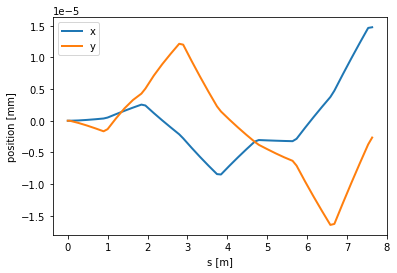

In [26]:
plt.plot(T[:,0], T[:,1], linewidth=2, label='x')
plt.plot(T[:,0], T[:,2], linewidth=2, label='y')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('position [mm]')

In [27]:
T = LINAC.get_transport_table('%S %emitt_x %emitt_y')

Text(0, 0.5, '$\\epsilon_n$ [mm.mrad]')

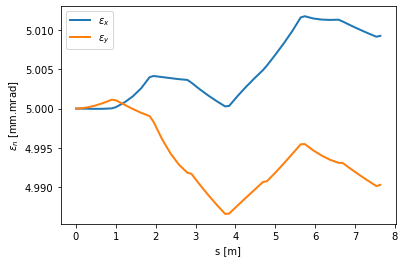

In [28]:
plt.plot(T[:,0], T[:,1], linewidth=2, label=r'$\epsilon_x$')
plt.plot(T[:,0], T[:,2], linewidth=2, label=r'$\epsilon_y$')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\epsilon_n$ [mm.mrad]')

In [29]:
#RF = RFT.Drift( RF.get_length());
#RF.set_static_Efield(0, 0, -E_max);

## Jitter amplification study
We paint an ellipse in the input phase space to evaluate the action amplification (jitter amplification)

In [30]:
N = 10
angles = np.linspace(0, 360, N)[:-1]

In [31]:
M0 = B0.get_phase_space()

sigma_X  = np.std(M0[:,0]) # mm
sigma_Xp = np.std(M0[:,1]) # mrad

T_X = []
T_XP = []

for angle in angles:
    print('angle=', angle)
    Mtemp = np.copy(M0)
    sx = np.std(M0[:,0])
    sy = np.std(M0[:,1])
    Mtemp[:,0] += 0.1*np.cos(np.deg2rad(angle))*sx
    Mtemp[:,1] += 0.1*np.sin(np.deg2rad(angle))*sy    
    Btemp = RFT.Bunch6d(mass, population, Q, Mtemp)
    B1 = LINAC.track(Btemp)  
    # do plots
    T = LINAC.get_transport_table('%mean_x %mean_Px')
    T_X = np.concatenate((T_X, T[:, 0]))
    T_XP = np.concatenate((T_XP, T[:, 1]))  
    
T_X = T_X.reshape((len(angles), int(T_X.size/len(angles))))
T_XP = T_XP.reshape((len(angles), int(T_XP.size/len(angles))))

angle= 0.0
angle= 40.0
angle= 80.0
angle= 120.0
angle= 160.0
angle= 200.0
angle= 240.0
angle= 280.0
angle= 320.0


In [32]:
T_X.size
T_X.shape

(9, 50)

In [33]:
plt.plot(T_X)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')

Text(0, 0.5, 'x [mm]')

Text(0.5, 1.0, 'Offsets at linac start')

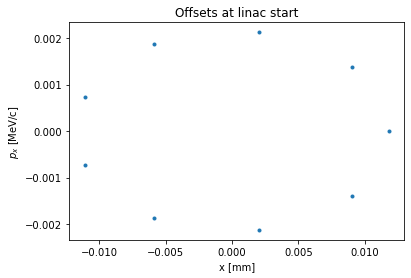

In [34]:
plt.plot(T_X[:,0], T_XP[:,0], '.')
plt.xlabel('x [mm]')
plt.ylabel(r'$p_x$ [MeV/c]')
plt.title('Offsets at linac start')

In [35]:
plt.plot(T_X[:,-1], T_XP[:,-1], '.')
plt.xlabel('x [mm]')
plt.ylabel(r'$p_x$ [MeV/c]')
plt.title('Offsets at linac end')

Text(0.5, 1.0, 'Offsets at linac end')

In [36]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [37]:
Ai = PolyArea(T_X[:, 0], T_XP[:, 0])

In [38]:
Af = PolyArea(T_X[:, -1], T_XP[:, -1])

In [39]:
Amplification_factor = np.sqrt(Af / Ai)
print(Amplification_factor)

1.0000347360186665
